In [2]:
%cd ..

/home/pauline/Dokumente/Delab_Projekt/delab


In [3]:
import pandas as pd

In [4]:
from util.sql_switch import get_query_native

#select all authors from the database

authors_tweets = get_query_native(
    "SELECT ta.id as author_id, conversation_id, screen_name , is_climate_author, climate_author_type FROM delab_tweet t, delab_tweetauthor ta WHERE t.author_id=ta.twitter_id")
#select only authors that are 'climate auhtors'
clauthors_tweets = authors_tweets.loc[authors_tweets['is_climate_author']== True]
clauthors_tweets = clauthors_tweets.replace(['non-governmental organisation'], 'NGO')

#group author by auhtor and conversations in order to analize the calculated variables for each author in each conversation
clauthors_tweets = clauthors_tweets.groupby(["author_id", "screen_name", "climate_author_type","conversation_id"]).mean()

#get needed variables from 'conversation' and 'conversation author metrics'
c_cam = get_query_native(
    "SELECT author_id, is_root_author, c.conversation_id, depth, branching_factor, centrality, baseline_vision, n_posts, root_dominance FROM delab_conversation c, delab_conversationauthormetrics cam WHERE c.conversation_id=cam.conversation_id")
c_cam = c_cam.groupby(["author_id", "conversation_id"]).mean()
c_cam = c_cam.loc[c_cam['is_root_author']==True]
#join both dataframes in order to match the climate author type with variables we want to analyze
analysis = clauthors_tweets.join(c_cam)
analysis_flattened = analysis.reset_index()
analysis_flattened

using postgres


/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


using postgres


/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance
0,1,1414150136607948808,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1427328275773280265,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1509780204948017154,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1521343957086740486,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1532708095704580100,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9137,1618,1610320983872634881,climate_ice,scientist,1.0,1.0,4.0,6.0,2.166667,0.285156,2.0,7.0
9138,1619,1519656711455313921,EricTopol,scientist,1.0,1.0,3.0,8.0,6.500000,0.500000,1.0,9.0
9139,1619,1530931490636255232,EricTopol,scientist,1.0,1.0,7.0,35.0,21.166667,0.250000,1.0,36.0
9140,1619,1593290345646694401,EricTopol,scientist,1.0,1.0,10.0,46.0,22.722222,0.500000,1.0,47.0


In [5]:
import networkx as nx

In [6]:
#calculate the total amount of tweets in each conversation
tweet_ids = get_query_native(
                "SELECT conversation_id FROM delab_tweet")
tweet_ids
tweet_count = tweet_ids['conversation_id'].value_counts()
tweet_count = tweet_count.to_frame()
tweet_count = tweet_count.rename(columns={"conversation_id":"n_posts"})
tweet_count['conversation_id'] = tweet_count.index
tweet_count

using postgres


/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,n_posts,conversation_id
1603181423787380737,190875,1603181423787380737
1608175680407191552,81226,1608175680407191552
1612973043583696897,77559,1612973043583696897
1607677190254235648,75456,1607677190254235648
1608188826291167242,43518,1608188826291167242
...,...,...
1312726721255309312,6,1312726721255309312
1281524980342304769,6,1281524980342304769
1318869648385970178,6,1318869648385970178
1277864596439777281,6,1277864596439777281


In [7]:
#add the total amount of tweets to the previous dataframe
mapped_columns = dict(zip(tweet_count.conversation_id, tweet_count.n_posts))
analysis_flattened["total_counts"] = analysis_flattened["conversation_id"].map(mapped_columns)
analysis_flattened

,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts
0,1,1414150136607948808,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,794
1,1,1427328275773280265,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,590
2,1,1509780204948017154,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,321
3,1,1521343957086740486,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
4,1,1532708095704580100,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,1618,1610320983872634881,climate_ice,scientist,1.0,1.0,4.0,6.0,2.166667,0.285156,2.0,7.0,7
9138,1619,1519656711455313921,EricTopol,scientist,1.0,1.0,3.0,8.0,6.500000,0.500000,1.0,9.0,9
9139,1619,1530931490636255232,EricTopol,scientist,1.0,1.0,7.0,35.0,21.166667,0.250000,1.0,36.0,36
9140,1619,1593290345646694401,EricTopol,scientist,1.0,1.0,10.0,46.0,22.722222,0.500000,1.0,47.0,47


In [8]:
#count how many conversation for each climate author type were downloaded
most_count = analysis_flattened.groupby('climate_author_type').count()
most_count

,author_id,conversation_id,screen_name,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts
climate_author_type,,,,,,,,,,,,
NGO,1973,1973,1973,1973,1744,1744,1744,1744,1744,1744,1744,1973
activist,1336,1336,1336,1336,1066,1066,1066,1066,1066,1066,1066,1336
journalist,970,970,970,970,838,838,838,838,838,838,838,970
organisation,1332,1332,1332,1332,1301,1301,1301,1301,1301,1301,1301,1332
politician,1185,1185,1185,1185,1073,1073,1073,1073,1073,1073,1073,1185
scientist,2346,2346,2346,2346,1883,1883,1883,1883,1883,1883,1883,2346


## Analyse
- Nach climate_author_type analysieren
- Fragen:
    - in wievielen Konversationen sind die Autoren durchschnittlich vertreten?
    - welche Zentralität haben die AUtoren durchschnittlich?
    - welche root dominance haben die Autoren durchschnittlich?
    - welchen branching_factor und welche depth haben die Konversationen, in denen die Autoren root auhtor sind duchschnittlich?
    

In [9]:
#group the previous dataframe by climate author type to analyze by author type
climate_analysis = analysis_flattened.groupby(['climate_author_type']).mean()
climate_analysis = climate_analysis.drop(columns=['author_id', 'conversation_id', 'is_climate_author', 'is_root_author' ])
climate_analysis

,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts
climate_author_type,,,,,,,
NGO,6.333716,96.807913,33.098114,0.383259,2.004014,97.696875,151.692347
activist,9.511257,211.167917,99.938173,0.361230,3.260788,212.080920,848.776198
journalist,7.571599,61.198091,17.453906,0.316467,3.278043,62.198091,126.280412
organisation,3.862414,31.230592,21.210071,0.456124,1.695619,32.169226,36.090841
politician,6.762349,153.401678,88.352143,0.392665,1.837838,154.401678,273.590717
scientist,8.860860,112.071163,40.939892,0.343446,3.231014,113.042101,240.592072


In [10]:
#same with median to compare to mean
median_analysis = analysis_flattened.groupby(['climate_author_type']).median()
median_analysis = median_analysis.drop(columns=['author_id', 'conversation_id', 'is_climate_author', 'is_root_author' ])
median_analysis

,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts
climate_author_type,,,,,,,
NGO,4.0,14.0,7.666667,0.500000,1.0,15.0,17.0
activist,7.0,42.0,14.208333,0.500000,1.0,43.0,65.0
journalist,5.0,21.0,7.000000,0.285156,2.0,22.0,26.0
organisation,3.0,12.0,9.000000,0.500000,1.0,13.0,14.0
politician,5.0,22.0,10.866667,0.500000,1.0,23.0,26.0
scientist,6.0,31.0,10.403016,0.500000,1.0,32.0,39.0


In [11]:
import matplotlib.pyplot as plt

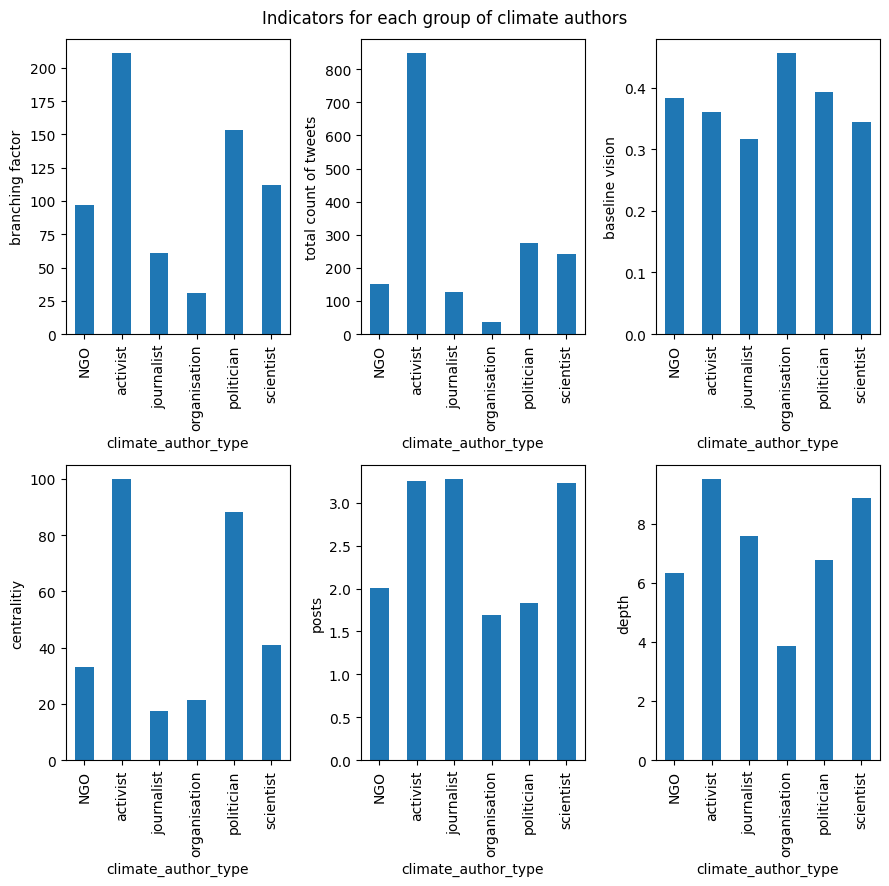

In [12]:
#plot mean of all conversations grouped by climate author type
fig, axes = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(9,9))
fig.suptitle("Indicators for each group of climate authors")

ax1 = climate_analysis['branching_factor'].plot.bar(ax=axes[0,0])
ax1.set_ylabel("branching factor")

ax2 = climate_analysis['total_counts'].plot.bar(ax=axes[0,1])
ax2.set_ylabel("total count of tweets")

ax3 = climate_analysis['centrality'].plot.bar(ax=axes[1,0])
ax3.set_ylabel("centralitiy")

ax4 = climate_analysis['n_posts'].plot.bar(ax=axes[1,1])
ax4.set_ylabel("posts");

ax5 = climate_analysis['baseline_vision'].plot.bar(ax=axes[0,2])
ax5.set_ylabel("baseline vision")

ax6 = climate_analysis['depth'].plot.bar(ax=axes[1,2])
ax6.set_ylabel("depth");

In [13]:
analysis_flattened.describe()

,author_id,conversation_id,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts
count,9142.000000,9.142000e+03,9142.0,7905.0,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,9142.000000
mean,383.670422,1.454809e+18,1.0,1.0,7.146869,108.979507,47.864585,0.376993,2.527514,109.926256,272.637607
std,237.701626,1.538300e+17,0.0,0.0,7.389131,351.667814,187.030324,0.162873,4.964834,351.682155,2880.595854
min,1.000000,3.629063e+17,1.0,1.0,2.000000,5.000000,0.068182,0.013889,1.000000,0.019231,6.000000
25%,317.000000,1.387702e+18,1.0,1.0,3.000000,9.000000,5.000000,0.250000,1.000000,10.000000,11.000000
50%,375.000000,1.503746e+18,1.0,1.0,5.000000,20.000000,9.205556,0.500000,1.000000,21.000000,25.000000
75%,401.000000,1.576478e+18,1.0,1.0,9.000000,62.000000,24.166667,0.500000,2.000000,63.000000,88.000000
max,1619.000000,1.622933e+18,1.0,1.0,113.000000,9285.000000,6652.180455,0.500000,113.000000,9286.000000,190875.000000


Following cells are to analysize wether dividing the variables by the total amount of tweets decreases the amount of outliers (it does).

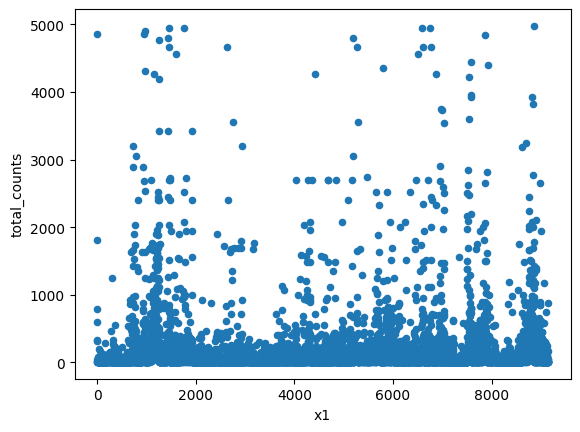

In [14]:
scatter_analysis = analysis_flattened.reset_index()
scatter_analysis = scatter_analysis[scatter_analysis.total_counts > 1]
scatter_analysis = scatter_analysis.drop(scatter_analysis[scatter_analysis['total_counts']>5000].index)
scatter_analysis['x1'] = scatter_analysis.index
scatter_analysis = scatter_analysis.sort_values('total_counts', ascending=True)
scatter_analysis
scatter_analysis.plot.scatter(x='x1', y="total_counts");

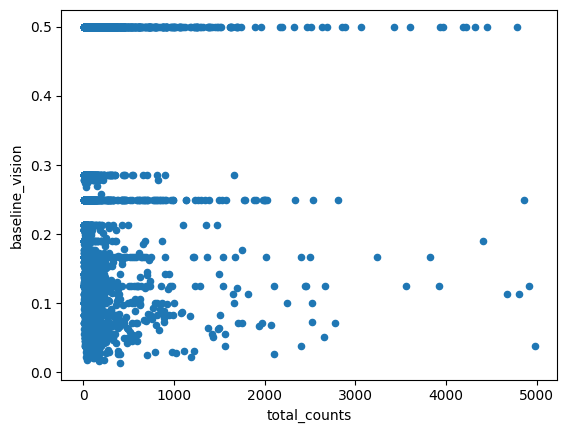

In [15]:
std = scatter_analysis['baseline_vision']
scatter_analysis.plot.scatter(x='total_counts', y= 'baseline_vision');

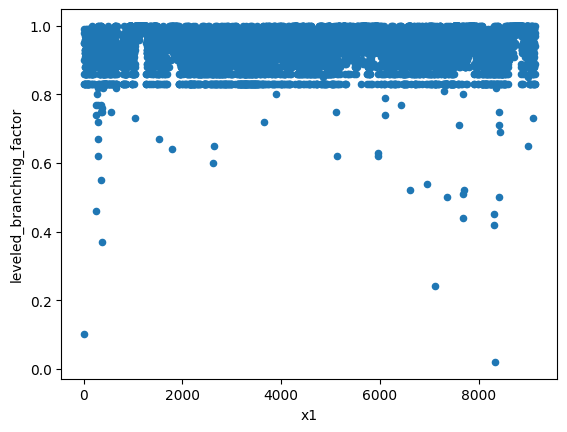

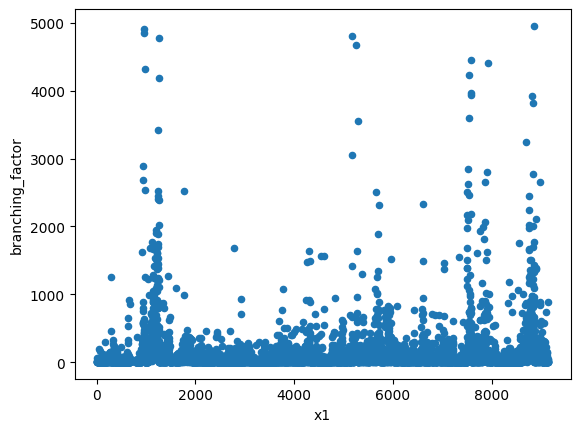

In [16]:
scatter_analysis['leveled_branching_factor']= (scatter_analysis["branching_factor"]/scatter_analysis["total_counts"]).round(2)
scatter_analysis.plot.scatter(x='x1', y="leveled_branching_factor")
scatter_analysis.plot.scatter(x='x1', y="branching_factor");

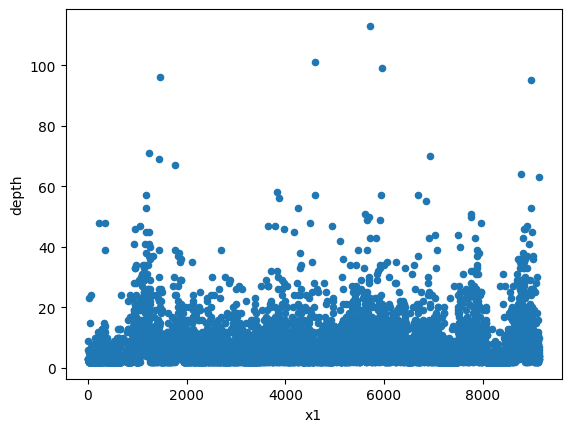

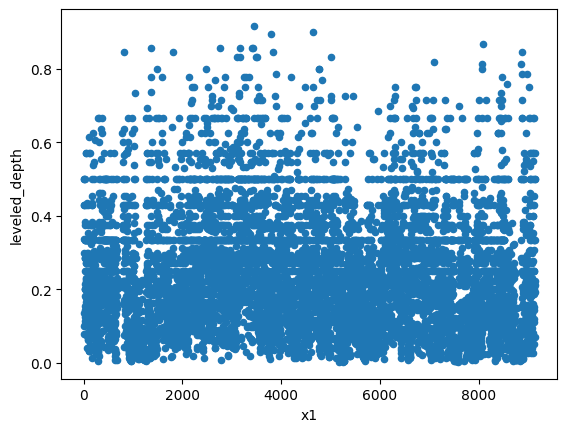

In [17]:
scatter_analysis.plot.scatter(x='x1', y="depth")
scatter_analysis['leveled_depth']= (scatter_analysis["depth"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_depth");

In [18]:
scatter_analysis

,index,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts,x1,leveled_branching_factor,leveled_depth
4560,4560,375,721739546610806789,sven_giegold,politician,1.0,1.0,2.0,5.0,5.000000,0.500000,1.0,6.0,6,4560,0.83,0.333333
2848,2848,344,1124663673933451266,fff_hamburg,NGO,1.0,1.0,3.0,5.0,3.500000,0.500000,1.0,6.0,6,2848,0.83,0.500000
8206,8206,434,1548940857084182530,UNEP,organisation,1.0,1.0,2.0,5.0,5.000000,0.500000,1.0,6.0,6,8206,0.83,0.333333
4706,4706,377,1401869295731150850,micha_bloss,politician,1.0,1.0,2.0,5.0,5.000000,0.500000,1.0,6.0,6,4706,0.83,0.333333
4707,4707,377,1402577374131195908,micha_bloss,politician,1.0,1.0,3.0,5.0,4.000000,0.500000,1.0,6.0,6,4707,0.83,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,6595,392,1596441230644477954,sascha_m_k,scientist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,6595,NaN,NaN
1449,1449,305,1596441230644477954,Perowinger94,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,1449,NaN,NaN
1769,1769,310,1596441230644477954,NurderK,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,1769,NaN,NaN
6756,6756,396,1596441230644477954,ConstZerger,scientist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,6756,NaN,NaN


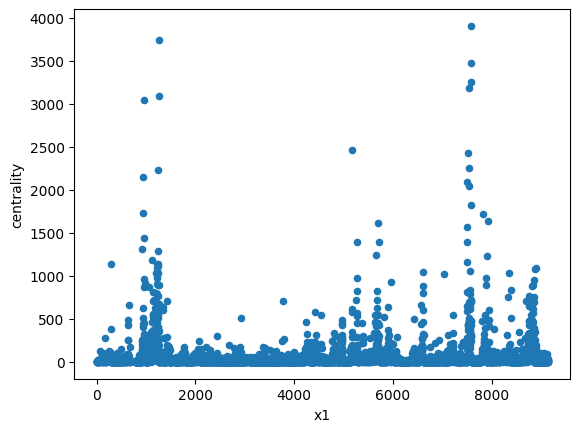

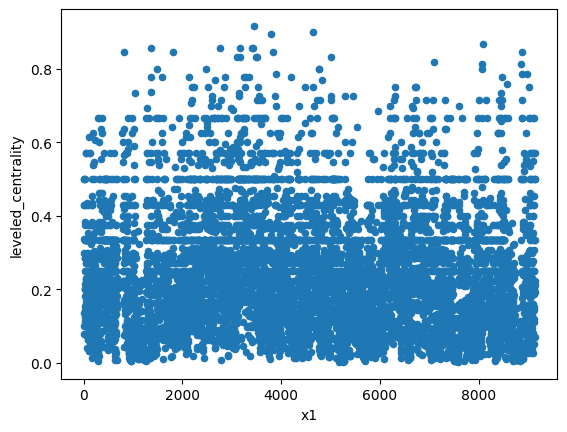

In [19]:
scatter_analysis.plot.scatter(x='x1', y="centrality")
scatter_analysis['leveled_centrality']= (scatter_analysis["depth"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_centrality");

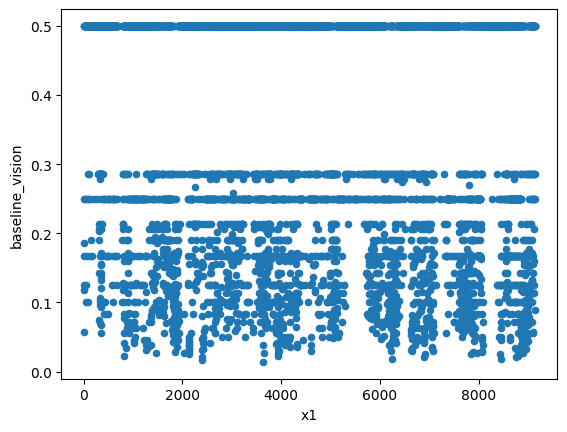

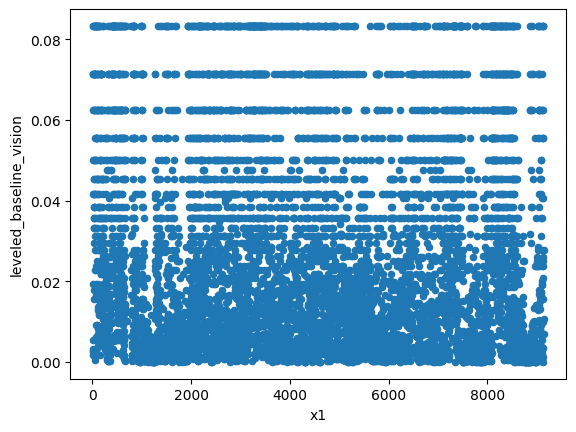

In [20]:
scatter_analysis.plot.scatter(x='x1', y="baseline_vision")
scatter_analysis['leveled_baseline_vision']= (scatter_analysis["baseline_vision"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_baseline_vision");

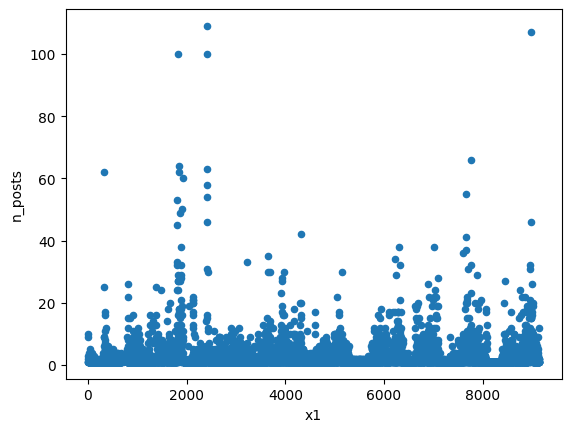

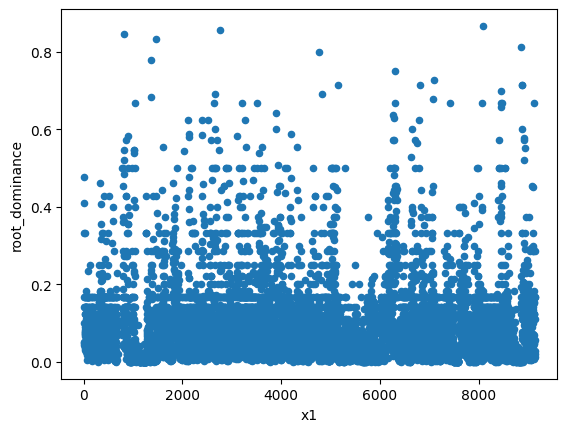

In [21]:
#n_posts divided by total counts of posts is the same as the root dominance from the delab_tree library
scatter_analysis.plot.scatter(x='x1', y="n_posts")
scatter_analysis['root_dominance']= (scatter_analysis["n_posts"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="root_dominance");

In [22]:
#group the variables divided by the total count of tweets by climate author type
leveled_analysis = scatter_analysis.groupby('climate_author_type').mean()
leveled_analysis

,index,author_id,conversation_id,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts,x1,leveled_branching_factor,leveled_depth,leveled_centrality,leveled_baseline_vision
climate_author_type,,,,,,,,,,,,,,,,,
NGO,3535.097611,311.074733,1.443559e+18,1.0,1.0,6.333716,96.807913,33.098114,0.383259,2.004014,0.109374,134.941535,3535.097611,0.926433,0.267158,0.267158,0.030789
activist,1957.616564,310.643405,1.440532e+18,1.0,1.0,9.447887,202.647887,93.785833,0.361099,3.262911,0.082979,297.383436,1957.616564,0.955390,0.190028,0.190028,0.016695
journalist,4104.990664,390.545643,1.449929e+18,1.0,1.0,7.571599,61.198091,17.453906,0.316467,3.278043,0.124588,92.522822,4104.990664,0.939749,0.272870,0.272870,0.021413
organisation,5136.436186,323.175676,1.447620e+18,1.0,1.0,3.862414,31.230592,21.210071,0.456124,1.695619,0.098001,36.090841,5136.436186,0.913859,0.237943,0.237943,0.037866
politician,5179.927844,398.578098,1.431114e+18,1.0,1.0,6.721082,148.309701,88.204966,0.392946,1.824627,0.090666,174.353141,5179.927844,0.941325,0.224747,0.224747,0.023540
scientist,6447.722437,509.151437,1.486347e+18,1.0,1.0,8.845377,109.169501,40.942985,0.343596,3.172689,0.093251,160.458172,6447.722437,0.948916,0.223760,0.223760,0.017937


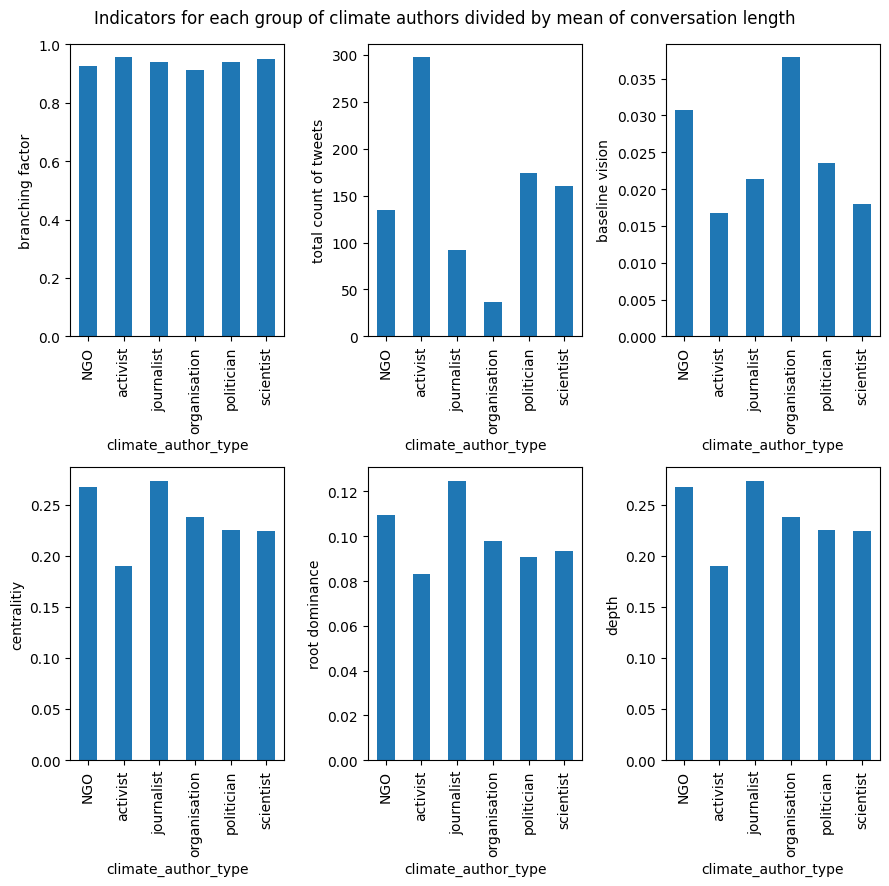

In [23]:
#plot the new dataframe in order to get results less sensitive to outliers
fig, axes = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(9,9))
fig.suptitle("Indicators for each group of climate authors divided by mean of conversation length")

ax1 = leveled_analysis['leveled_branching_factor'].plot.bar(ax=axes[0,0])
ax1.set_ylabel("branching factor")

ax2 = leveled_analysis['total_counts'].plot.bar(ax=axes[0,1])
ax2.set_ylabel("total count of tweets")

ax3 = leveled_analysis['leveled_centrality'].plot.bar(ax=axes[1,0])
ax3.set_ylabel("centralitiy")

ax4 = leveled_analysis['root_dominance'].plot.bar(ax=axes[1,1])
ax4.set_ylabel("root dominance");

ax5 = leveled_analysis['leveled_baseline_vision'].plot.bar(ax=axes[0,2])
ax5.set_ylabel("baseline vision")

ax6 = leveled_analysis['leveled_depth'].plot.bar(ax=axes[1,2])
ax6.set_ylabel("depth");

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(leveled_analysis)
normalized_df = pd.DataFrame(normalized_data, columns=leveled_analysis.columns)
author_types = ['NGO', 'activists', 'journalists', 'organisations', 'politicians', 'scientists'] 
normalized_df['author_type'] = author_types
normalized_df = normalized_df.set_index('author_type')
normalized_df

,index,author_id,conversation_id,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts,x1,leveled_branching_factor,leveled_depth,leveled_centrality,leveled_baseline_vision
author_type,,,,,,,,,,,,,,,,,
NGO,0.351324,0.002173,0.225317,0.0,0.0,0.442452,0.382560,0.204950,0.478258,0.194888,0.634367,0.378314,0.351324,0.302783,0.931045,0.931045,0.665745
activists,0.000000,0.000000,0.170526,0.0,0.0,1.000000,1.000000,1.000000,0.319584,0.990437,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
journalists,0.478246,0.402514,0.340660,0.0,0.0,0.664077,0.174822,0.000000,0.000000,1.000000,1.000000,0.215972,0.478246,0.623408,1.000000,1.000000,0.222871
organisations,0.707961,0.063132,0.298852,0.0,0.0,0.000000,0.000000,0.049208,1.000000,0.000000,0.361031,0.000000,0.707961,0.000000,0.578389,0.578389,1.000000
politicians,0.717647,0.442978,0.000000,0.0,0.0,0.511804,0.683006,0.926887,0.547621,0.081526,0.184750,0.529147,0.717647,0.661337,0.419105,0.419105,0.323340
scientists,1.000000,1.000000,1.000000,0.0,0.0,0.892129,0.454674,0.307723,0.194255,0.933422,0.246862,0.475970,1.000000,0.844126,0.407183,0.407183,0.058670


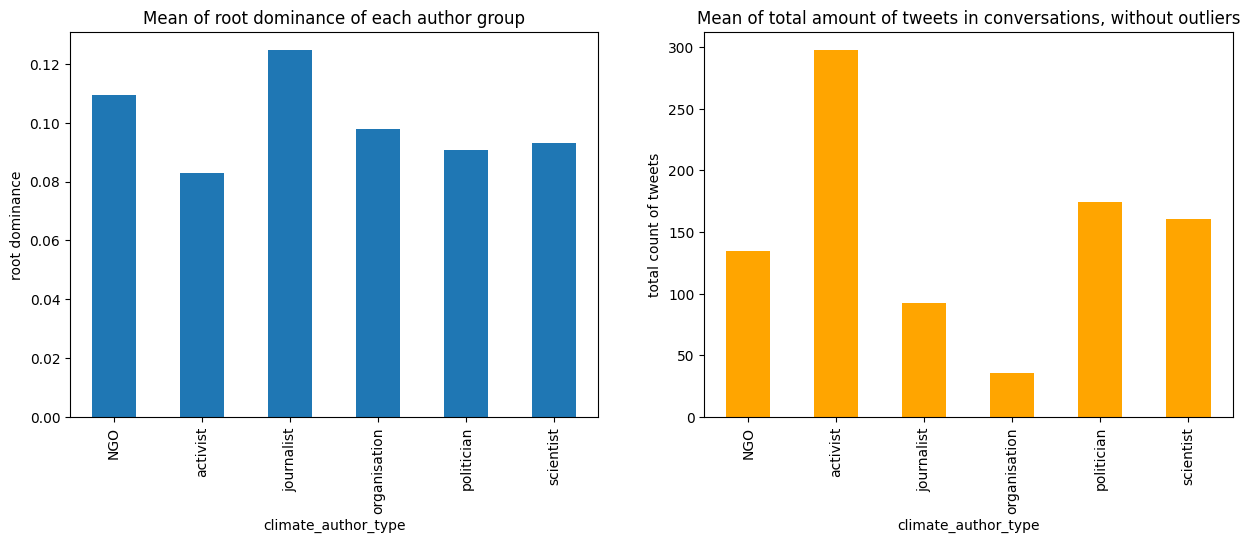

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1 = leveled_analysis['root_dominance'].plot.bar(ax=axes[0])
ax1.set_ylabel("root dominance")
ax1.set_title("Mean of root dominance of each author group")
ax2 = leveled_analysis['total_counts'].plot.bar(ax=axes[1], color='orange')
ax2.set_ylabel("total count of tweets")
ax2.set_title("Mean of total amount of tweets in conversations, without outliers");

In [48]:
scatter_analysis

,index,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts,x1,leveled_branching_factor,leveled_depth,leveled_centrality,leveled_baseline_vision
4560,4560,375,721739546610806789,sven_giegold,politician,1.0,1.0,2.0,5.0,5.000000,0.500000,1.0,0.166667,6,4560,0.83,0.333333,0.333333,0.083333
2848,2848,344,1124663673933451266,fff_hamburg,NGO,1.0,1.0,3.0,5.0,3.500000,0.500000,1.0,0.166667,6,2848,0.83,0.500000,0.500000,0.083333
8206,8206,434,1548940857084182530,UNEP,organisation,1.0,1.0,2.0,5.0,5.000000,0.500000,1.0,0.166667,6,8206,0.83,0.333333,0.333333,0.083333
4706,4706,377,1401869295731150850,micha_bloss,politician,1.0,1.0,2.0,5.0,5.000000,0.500000,1.0,0.166667,6,4706,0.83,0.333333,0.333333,0.083333
4707,4707,377,1402577374131195908,micha_bloss,politician,1.0,1.0,3.0,5.0,4.000000,0.500000,1.0,0.166667,6,4707,0.83,0.500000,0.500000,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,6595,392,1596441230644477954,sascha_m_k,scientist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,6595,NaN,NaN,NaN,NaN
1449,1449,305,1596441230644477954,Perowinger94,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,1449,NaN,NaN,NaN,NaN
1769,1769,310,1596441230644477954,NurderK,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,1769,NaN,NaN,NaN,NaN
6756,6756,396,1596441230644477954,ConstZerger,scientist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,6756,NaN,NaN,NaN,NaN


In [67]:
scaler = MinMaxScaler()

analize = scatter_analysis.drop('screen_name', axis=1)
map_dict = {'NGO': 0.0, 'politician': 0.2, 'activist':0.3, 'organisation': 0.4, 'journalist': 0.6, 'politician': 0.8, 'scientist': 1.0}
analize = analize.replace(map_dict)

normalized_data = scaler.fit_transform(analize)
normalized_df = pd.DataFrame(normalized_data, columns=analize.columns)
author_types = ['NGO', 'activists', 'journalists', 'organisations', 'politicians', 'scientists'] 
#normalized_df['author_type'] = author_types
#normalized_df = normalized_df.set_index('author_type')
normalized_df

,index,author_id,conversation_id,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts,x1,leveled_branching_factor,leveled_depth,leveled_centrality,leveled_baseline_vision
0,0.498851,0.231150,0.284782,0.8,0.0,0.0,0.000000,0.0,0.001262,1.000000,0.000000,0.192113,0.000000,0.498851,0.826531,0.361547,0.361547,1.0
1,0.311563,0.211990,0.604556,0.0,0.0,0.0,0.009009,0.0,0.000878,1.000000,0.000000,0.192113,0.000000,0.311563,0.826531,0.543962,0.543962,1.0
2,0.897714,0.267614,0.941277,0.4,0.0,0.0,0.000000,0.0,0.001262,1.000000,0.000000,0.192113,0.000000,0.897714,0.826531,0.361547,0.361547,1.0
3,0.514823,0.232386,0.824556,0.8,0.0,0.0,0.000000,0.0,0.001262,1.000000,0.000000,0.192113,0.000000,0.514823,0.826531,0.361547,0.361547,1.0
4,0.514933,0.232386,0.825118,0.8,0.0,0.0,0.009009,0.0,0.001006,1.000000,0.000000,0.192113,0.000000,0.514933,0.826531,0.543962,0.543962,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9071,0.721475,0.241656,0.978975,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.992558,0.721475,NaN,NaN,NaN,NaN
9072,0.158517,0.187886,0.978975,0.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.992558,0.158517,NaN,NaN,NaN,NaN
9073,0.193524,0.190977,0.978975,0.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.992558,0.193524,NaN,NaN,NaN,NaN
9074,0.739088,0.244129,0.978975,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.992558,0.739088,NaN,NaN,NaN,NaN


In [68]:
analize

,index,author_id,conversation_id,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts,x1,leveled_branching_factor,leveled_depth,leveled_centrality,leveled_baseline_vision
4560,4560,375,721739546610806789,0.8,1.0,1.0,2.0,5.0,5.000000,0.500000,1.0,0.166667,6,4560,0.83,0.333333,0.333333,0.083333
2848,2848,344,1124663673933451266,0.0,1.0,1.0,3.0,5.0,3.500000,0.500000,1.0,0.166667,6,2848,0.83,0.500000,0.500000,0.083333
8206,8206,434,1548940857084182530,0.4,1.0,1.0,2.0,5.0,5.000000,0.500000,1.0,0.166667,6,8206,0.83,0.333333,0.333333,0.083333
4706,4706,377,1401869295731150850,0.8,1.0,1.0,2.0,5.0,5.000000,0.500000,1.0,0.166667,6,4706,0.83,0.333333,0.333333,0.083333
4707,4707,377,1402577374131195908,0.8,1.0,1.0,3.0,5.0,4.000000,0.500000,1.0,0.166667,6,4707,0.83,0.500000,0.500000,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,6595,392,1596441230644477954,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,6595,NaN,NaN,NaN,NaN
1449,1449,305,1596441230644477954,0.3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,1449,NaN,NaN,NaN,NaN
1769,1769,310,1596441230644477954,0.3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,1769,NaN,NaN,NaN,NaN
6756,6756,396,1596441230644477954,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,6756,NaN,NaN,NaN,NaN
